In [1]:
# Set full width on jupyter notebook navigator
from IPython.core.display import HTML, display

display(HTML("<style>.container { width:100% !important; }</style>"))

# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Water potability pipeline

Based on the [Kaggle Challenge Drinking_Water_Potability](https://www.kaggle.com/artimule/drinking-water-probability)

**Context**
Access to safe drinking water is essential to health, a basic human right, and a component of effective policy for health protection. This is important as a health and development issue at a national, regional, and local level. In some regions, it has been shown that investments in water supply and sanitation can yield a net economic benefit, since the reductions in adverse health effects and health care costs outweigh the costs of undertaking the interventions.

**Content**
The drinking_water_potability.csv file contains water quality metrics for 3276 different water bodies.

The purpose of this notebook is to define the whole pipeline to process and predict our data.

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

First we import and vizualize our data (for more a more detailed analysis, see this [notebook]())  

In [3]:
dataset = pd.read_csv("./drinking_water_potability.csv")
dataset.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890456,20791.31898,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.05786,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.54173,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.41744,8.059332,356.886136,363.266516,18.436525,100.341674,4.628771,0
4,9.092223,181.101509,17978.98634,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


We then split our data into two part 75% for the train set and 25% for the test set.   
The test set will only be used at the very end to evaluate the final result of our model. 

In [4]:
train_set, test_set = train_test_split(
    dataset, train_size=0.75, random_state=42, stratify=dataset["Potability"]
)

target = "Potability"
feature_names = list(filter(lambda x: x != target, train_set.columns))

print(f"Elements in train: {train_set.shape[0]}")
print(f"Elements in test : {test_set.shape[0]}")
print(train_set["Potability"].value_counts() / train_set.shape[0])
print(test_set["Potability"].value_counts() / test_set.shape[0])

Elements in train: 2457
Elements in test : 819
0    0.609687
1    0.390313
Name: Potability, dtype: float64
0    0.610501
1    0.389499
Name: Potability, dtype: float64


# 1. Data Processing

## 1.1 [Data Processing] Removing the outliers before starting

The first set of data processing is to deal with the potential outliers seen in the dataset.  

We defined the outliers as: "Waters with ($pH <= 1$  or  $pH>13$) and $(Potability=1)$."

Since there is only a handful of datapoint that can be considered as outliers (see EDA notebook), we decided to remove these few outliers from the dataset

In [5]:
from utils import process_remove_outliers_ph

processors = [process_remove_outliers_ph]

In [6]:
print("=" * 10, "TRAIN", "=" * 10)
print(f"Initial size: {train_set.shape}")
for processor in processors:
    train_set = processor(train_set)
    print(f"Apply {processor.__name__}, new size: {train_set.shape}")

print("\n" * 2, "=" * 10, "TEST", "=" * 10)
print(f"Initial size: {test_set.shape}")
for processor in processors:
    test_set = processor(test_set)
    print(f"Apply {processor.__name__}, new size: {test_set.shape}")

========== TRAIN ==========
Initial size: (2457, 10)
Apply process_remove_outliers_ph, new size: (2455, 10)


 ========== TEST ==========
Initial size: (819, 10)
Apply process_remove_outliers_ph, new size: (818, 10)


In total 3 datapoints out of 3276 (ie. < 0.1%) were removed

## 1.2 [Data Processing] All the transformers and steps of the pipeline

### 1.2.1 Definition of the transformer pipeline

After removing the outliers we need to deal with the missing values and scale the data.   
For the missing values after careful analysis we decided to choose a Multivariate Imputer.   
For the scaler, we used a standard scaler since all the features present a gaussian distribution. 

In [7]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

transformer = Pipeline(
    [
        ("Missing_values_handler", IterativeImputer(max_iter=10, random_state=0, sample_posterior=True)),
        ("Scaler", StandardScaler()),
    ]
)
transformer

Pipeline(steps=[('Missing_values_handler',
                 IterativeImputer(random_state=0, sample_posterior=True)),
                ('Scaler', StandardScaler())])

# 2. Modeling

## 2.1 [Modeling] Exploration of 11 classifiers 

In [9]:
feature_names

['ph',
 'Hardness',
 'Solids',
 'Chloramines',
 'Sulfate',
 'Conductivity',
 'Organic_carbon',
 'Trihalomethanes',
 'Turbidity']

#### WHO limits for drinkable water
- `6.5 < pH < 8.5`
- Desirable limit: `Solids < 500 mg/L` | Maximum limit: `Solids < 1000 mg/L`
- `Chloramines < 4 mg/L = 4 ppm`
- In seawater: `Sulfate ~ 2.7 mg/L` | In most fresh water supplies: `3 < Sulfate < 30 mg/L` | In some geographic locations: `Sulfate = 1000 mg/L`
- `Conductivity < 400 µS/cm`
- `Organic_carbon < 2 mg/L` in treated/drinking water | `Organic_carbon < 4 mg/L` in source water used for treatment
- `Trihalomethanes < 80 ppm`
- Recommended value: `Turbidity = 5.00 NTU`


First we define our baseline as te OMSClassifier: a Naïve rule based classifier that classifies water as drinkable if the pH>6.5 and pH<8.5 and Trihalomethanes<80.   
Detailed results for this classifier can be found [here]()

In [10]:
# Add the OMS Model
from sklearn.base import BaseEstimator, ClassifierMixin
def oms_recommendation(row):
    """Check the OMS recommendations."""
    return int(6.5 <= row[1] <= 8.5 and row[7] <= 80)

scores = {"name": "OMS"}
class OMSClassifier(BaseEstimator, ClassifierMixin):
    
    def __init__(self, scaler):
        self.columns = []
        self.scaler = scaler
        pass
    def fit(self, X, y):
        pass
    def predict(self, X):
        X_copy = self.scaler.inverse_transform(X, copy=True)
        return np.logical_and(6.5<X_copy[:,0], X_copy[:,0]<8.6, X_copy[:,7]<=80).astype(int)

Then we compare the 11 selected models based on the accuracy, f1-score and precision : 
- OMSClassifier
- LogisticRegression
- DummyClassifier
- DummyClassifier
- GaussianNB
- AdaBoostClassifier
- ExtraTreesClassifier
- GradientBoostingClassifier
- DecisionTreeClassifier
- SVM
- RandomForestClassifier
- KNeighborsClassifier

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    make_scorer,
    precision_score,
    recall_score,
)
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    AdaBoostClassifier,
    ExtraTreesClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
)

models = [
    OMSClassifier(transformer.named_steps["Scaler"]),
    DummyClassifier(),
    DecisionTreeClassifier(max_depth=7),
    LogisticRegression(),
    SVC(),
    KNeighborsClassifier(),
    GaussianNB(),
    RandomForestClassifier(),
    ExtraTreesClassifier(n_estimators=10),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
]

metrics = [accuracy_score, f1_score, precision_score, recall_score]
results = []

X_train, X_val, y_train, y_val = train_test_split(
    train_set[feature_names], train_set[target], train_size=0.8, random_state=20
)
transformer = transformer.fit(X_train,y_train)

for model in tqdm(models, desc="Training different models", unit="model"):
    scores = {"name": model.__class__.__name__}
    if model.__class__.__name__ != 'OMSClassifier':
        model = Pipeline([("transformer", transformer), ("model", model)])
        scores = {
            **scores,
            **{
                "cv_"
                + func.__name__: np.mean(
                    cross_val_score(
                        model, X_train, y_train, cv=5, scoring=make_scorer(func)
                    )
                )
                for func in metrics
            },
        }
        results.append(scores)
    else:
        model = Pipeline([("transformer", transformer), ("model", model)])
        X_train_oms, X_val_oms, y_train_oms, y_val_oms = train_test_split(
            X_train, y_train, train_size=0.8, random_state=20)
        model.fit(X_train_oms,y_train_oms)
        scores = {
            **scores,
            **{
                "cv_"
                + func.__name__: func(model.predict(X_val_oms),y_val_oms) for func in metrics
                },
            }
        results.append(scores)
    
results_df = pd.DataFrame.from_records(results)

Training different models: 100%|██████████| 11/11 [04:24<00:00, 24.05s/model]


In [12]:
results_df.sort_values(by=["cv_f1_score"], ascending=False)

,name,cv_accuracy_score,cv_f1_score,cv_precision_score,cv_recall_score
0,OMSClassifier,0.577608,0.495726,0.556250,0.465241
5,KNeighborsClassifier,0.626270,0.448335,0.531267,0.390052
7,RandomForestClassifier,0.661400,0.427793,0.604998,0.332934
4,SVC,0.663959,0.395411,0.671025,0.280893
2,DecisionTreeClassifier,0.626788,0.382642,0.577535,0.297725
8,ExtraTreesClassifier,0.622716,0.382094,0.496955,0.292530
10,GradientBoostingClassifier,0.630347,0.369390,0.561070,0.284798
9,AdaBoostClassifier,0.597767,0.331693,0.477120,0.254851
6,GaussianNB,0.624739,0.314155,0.551945,0.219727
1,DummyClassifier,0.608453,0.000000,0.000000,0.000000


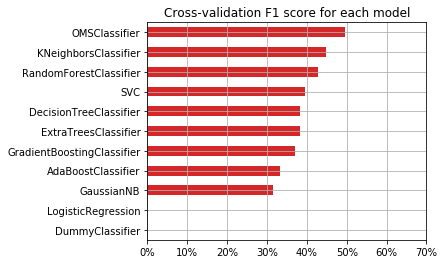

In [13]:
import matplotlib.ticker as mtick

fig = plt.figure(1, (5,4))
ax = fig.add_subplot(1,1,1)

xticks = mtick.FuncFormatter("{:.0%}".format)
ax.xaxis.set_major_formatter(xticks)

results_df.set_index("name")["cv_f1_score"].sort_values().rename_axis(None).plot.barh(
    xlim=[0, 0.7],
    grid=True, 
    title="Cross-validation F1 score for each model", 
    color='C3',
);


By comparing the different results we decided to go ahead with the top 3 models: 
- K-NN
- RandomForest 
- SVM 

We now need to finetune these models in order to find the best set of hyperparameters. 

## 2.2 [Modeling] Finetuning of the 3 best models

In [14]:
X_train, y_train = train_set[feature_names], train_set[target]
X_test, y_test = test_set[feature_names], test_set[target]

In [15]:
from sklearn.model_selection import GridSearchCV


def generate_results(model_name: str) -> pd.DataFrame:
    """Compute the grid search and output the results."""
    MODEL_DATA = MODELS[model_name]

    METRICS = ["f1_weighted", "accuracy", "average_precision"]

    param_grid = {"model__" + k: v for k, v in MODEL_DATA["param_grid"].items()}
    pipeline_gs = Pipeline([
        ("transformer", transformer),
        ("model", MODEL_DATA['model']())
    ])
    grid_search = GridSearchCV(
        pipeline_gs,
        param_grid=param_grid,
        cv=5,
        verbose=1,
        n_jobs=-1,
        scoring=METRICS,
        refit=False,
    )
    grid_search.fit(X_train, y_train);

    results = pd.DataFrame(grid_search.cv_results_)
    results = results.drop(columns=[x for x in results.columns if x.startswith("split")])
    results = results.sort_values(by=["mean_test_f1_weighted"], ascending=False).reset_index(
        drop=True
    )

    return results

In [16]:
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype

def generate_graphics(results: pd.DataFrame):
    """Generate the graphics for the different params."""
    param_cols = [x for x in results.columns if x.startswith("param_model")]

    for x in param_cols:
        results[x] = results[x].apply(lambda x: "None" if x is None else x)

    fig, axes = plt.subplots(len(param_cols), 3, figsize=(20,10))
    for i, param in enumerate(param_cols):
        for j, metric in enumerate(["f1_weighted", "accuracy", "average_precision"]):
            ax  = axes[i,j]
            ax.title.set_text(f"{metric} for {param}")
            ax.set_xlabel(param)
            ax.set_ylabel(metric)

            df = results.groupby(by=[param]).mean().sort_index()
            x_values = df.index
            y_values = df[f'mean_test_{metric}']
            y_std = df[f'std_test_{metric}']

            if isinstance(results.at[0, param], (int, float, np.float64, np.int64)):
                ax.plot(x_values, y_values)
                ax.fill_between(x_values, y_values-y_std, y_values+y_std, alpha=0.5)
            else:
                ax.plot(x_values, y_values)
                ax.errorbar(x_values, y_values, y_std, linestyle='None', marker='^')

            plt.tight_layout()

In [17]:
MODELS = {}

###  2.2.1 Knn

In [18]:
# Knn
MODEL_DATA = {}

MODEL_DATA['param_grid'] = {
    "weights": ["uniform", "distance"],
    "n_neighbors": [1, 2, 3, 5, 7, 10]
}

MODEL_DATA['model'] = KNeighborsClassifier

MODELS['Knn'] = MODEL_DATA

In [19]:
knn_results = generate_results('Knn')

Fitting 5 folds for each of 12 candidates, totalling 60 fits


In [20]:
knn_results.head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__n_neighbors,param_model__weights,params,mean_test_f1_weighted,std_test_f1_weighted,rank_test_f1_weighted,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,mean_test_average_precision,std_test_average_precision,rank_test_average_precision
0,2.532959,0.074307,1.180035,0.049821,10,distance,"{'model__n_neighbors': 10, 'model__weights': '...",0.604781,0.018035,1,0.630550,0.014889,1,0.508158,0.012880,2
1,1.990788,0.073869,1.248155,0.300936,5,uniform,"{'model__n_neighbors': 5, 'model__weights': 'u...",0.599697,0.012906,2,0.614664,0.010256,6,0.462995,0.011611,8
2,2.524419,0.326738,2.129810,0.144361,7,uniform,"{'model__n_neighbors': 7, 'model__weights': 'u...",0.598677,0.022586,3,0.616701,0.019888,4,0.482422,0.005701,6


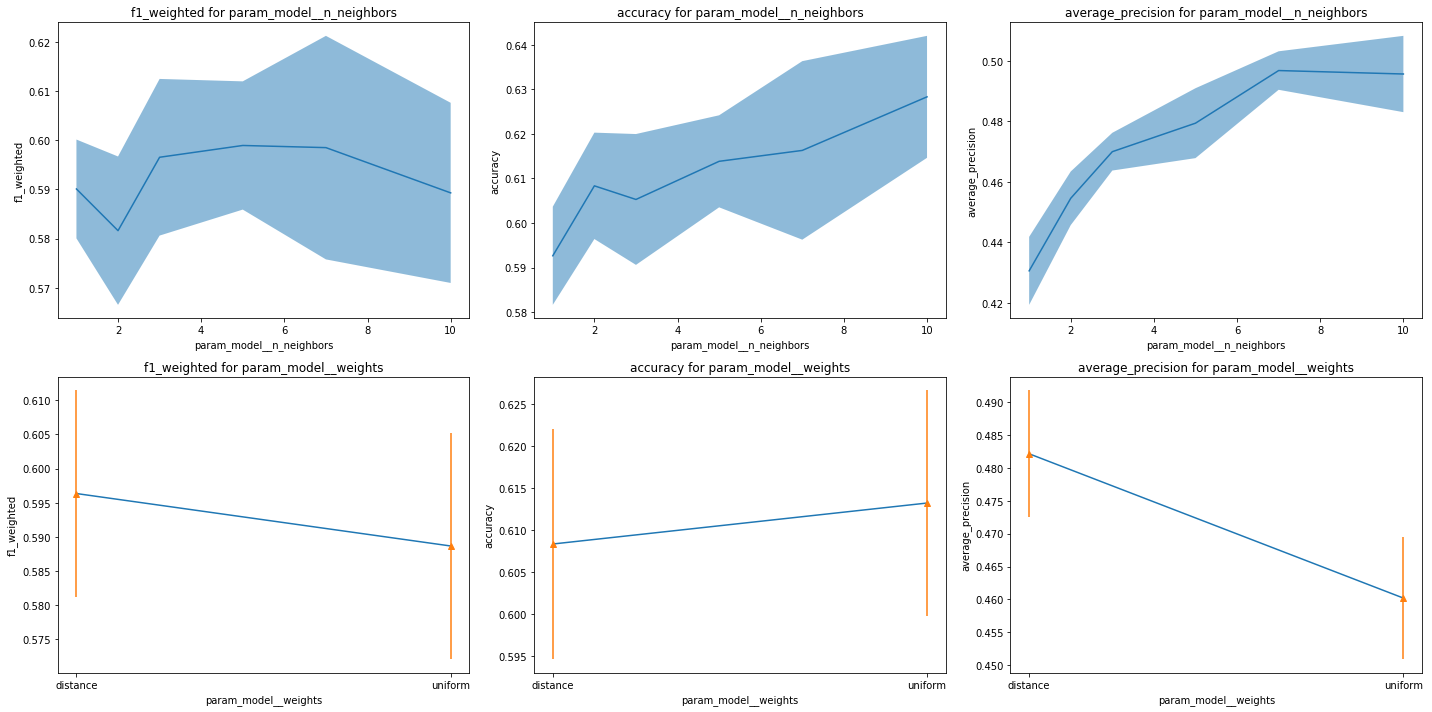

In [21]:
generate_graphics(knn_results)

###  2.2.2 Random Forest

In [22]:
# RandomForest
MODEL_DATA = {}

MODEL_DATA['param_grid'] = {
    "n_estimators": [10, 25, 50, 75, 100, 125, 150],
    "max_depth": [None, 3, 5, 8, 10, 15, 20, 30, 40]
}

MODEL_DATA['model'] = RandomForestClassifier

MODELS['RandomForest'] = MODEL_DATA

In [23]:
random_forest_results = generate_results('RandomForest')
random_forest_results['param_model__max_depth'] = random_forest_results['param_model__max_depth'].apply(lambda x: -1 if x is None else x)

Fitting 5 folds for each of 63 candidates, totalling 315 fits


In [24]:
random_forest_results.head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__max_depth,param_model__n_estimators,params,mean_test_f1_weighted,std_test_f1_weighted,rank_test_f1_weighted,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,mean_test_average_precision,std_test_average_precision,rank_test_average_precision
0,3.807227,0.425448,1.271340,0.153704,40,100,"{'model__max_depth': 40, 'model__n_estimators'...",0.638756,0.005985,1,0.665173,0.004387,5,0.565041,0.013478,15
1,2.876046,0.063557,0.855904,0.059556,20,150,"{'model__max_depth': 20, 'model__n_estimators'...",0.638349,0.011732,2,0.665988,0.011806,2,0.562611,0.009777,19
2,2.869265,0.095996,0.975188,0.096692,30,100,"{'model__max_depth': 30, 'model__n_estimators'...",0.638328,0.011126,3,0.665173,0.008003,5,0.566054,0.011802,11


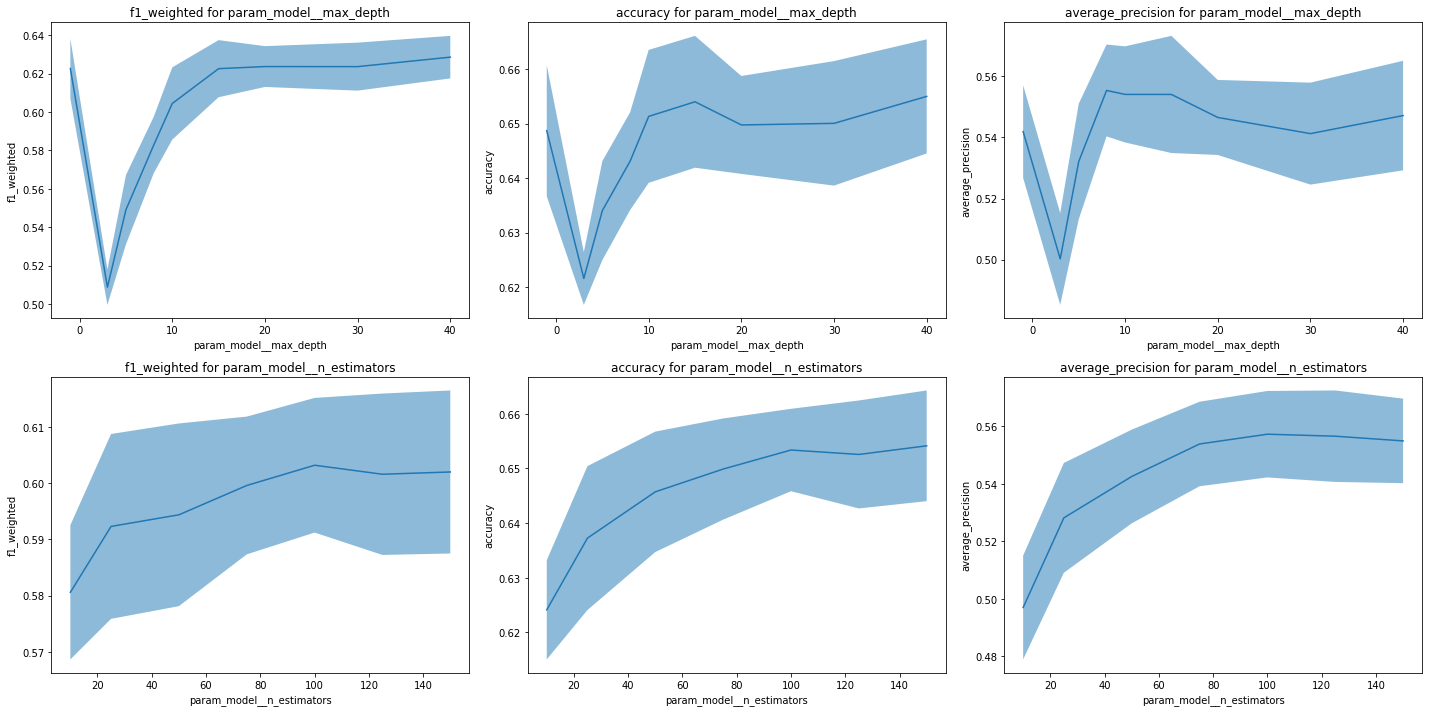

In [25]:
generate_graphics(random_forest_results)

###  2.2.3 SVM

In [26]:
# SVM
MODEL_DATA = {}

MODEL_DATA['param_grid'] = {
    "C": [0.1, 5, 10, 20, 50],
    "kernel": ["linear", "poly", "sigmoid", "rbf"],
    "class_weight": [None, "balanced"],
}

MODEL_DATA['model'] = SVC

MODELS['SVM'] = MODEL_DATA

In [27]:
svm_results = generate_results("SVM")

Fitting 5 folds for each of 40 candidates, totalling 200 fits


In [28]:
svm_results.head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__C,param_model__class_weight,param_model__kernel,params,mean_test_f1_weighted,std_test_f1_weighted,rank_test_f1_weighted,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,mean_test_average_precision,std_test_average_precision,rank_test_average_precision
0,2.161684,0.068171,1.103296,0.055935,10,None,rbf,"{'model__C': 10, 'model__class_weight': None, ...",0.638359,0.009917,1,0.652546,0.011051,2,0.560156,0.013021,4
1,2.306659,0.059696,1.244935,0.063289,5,balanced,rbf,"{'model__C': 5, 'model__class_weight': 'balanc...",0.637850,0.016650,2,0.636660,0.017406,5,0.563867,0.018951,3
2,1.933500,0.072638,1.074233,0.078580,5,None,rbf,"{'model__C': 5, 'model__class_weight': None, '...",0.635261,0.008882,3,0.655804,0.011521,1,0.567246,0.011374,2


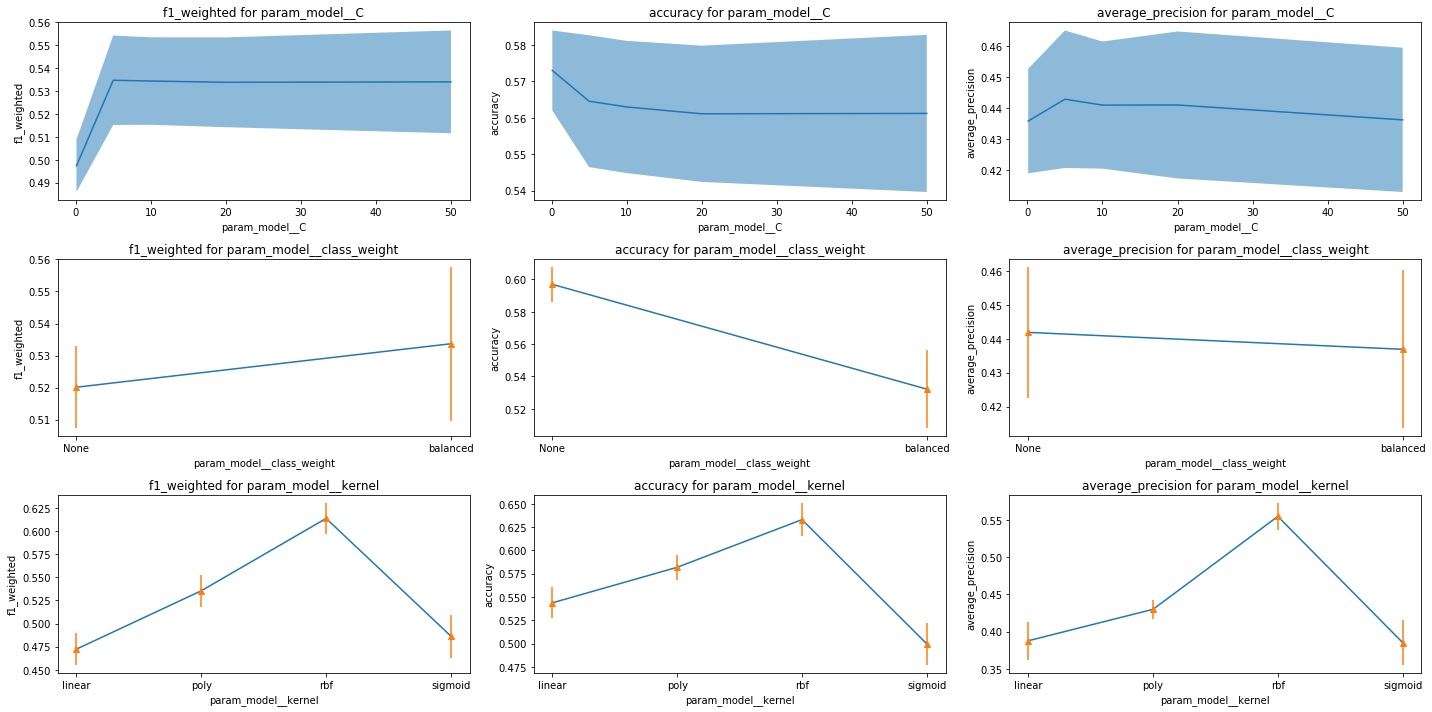

In [29]:
generate_graphics(svm_results)

## 2.3 [Modeling] Final model training - voting with the bests models

In [30]:
from sklearn.ensemble import VotingClassifier
from typing import Dict, Any

In [31]:
# We select the best results

KNN_IDX = 0
SVM_IDX = 1
RAND_FOREST_IDX = 0

def replace_params(x: Dict[str, Any]) -> Dict[str, Any]:
    return {
        k.replace('model__', ""):v for k,v in x.items()
    }

In [32]:
model = VotingClassifier(
    estimators=[
        ("svc", SVC(**replace_params(svm_results.at[SVM_IDX, "params"]))),
        ("knn", KNeighborsClassifier(**replace_params(knn_results.at[SVM_IDX, "params"]))),
        ("Random_forest", RandomForestClassifier(**replace_params(random_forest_results.at[RAND_FOREST_IDX, "params"]))),
    ],
    voting="hard",
)

#model = KNeighborsClassifier(**replace_params(knn_results.at[SVM_IDX, "params"]))
#model = SVC(**replace_params(svm_results.at[SVM_IDX, "params"]))
#model = RandomForestClassifier(**replace_params(random_forest_results.at[RAND_FOREST_IDX, "params"]))

pipeline = Pipeline([("transformer", transformer), ("model", model)], verbose=True)

In [33]:
pipeline.fit(X_train, y_train)

[Pipeline] ....... (step 1 of 2) Processing transformer, total=   1.4s
[Pipeline] ............. (step 2 of 2) Processing model, total=   1.1s


Pipeline(steps=[('transformer',
                 Pipeline(steps=[('Missing_values_handler',
                                  IterativeImputer(random_state=0,
                                                   sample_posterior=True)),
                                 ('Scaler', StandardScaler())])),
                ('model',
                 VotingClassifier(estimators=[('svc',
                                               SVC(C=5,
                                                   class_weight='balanced')),
                                              ('knn', KNeighborsClassifier()),
                                              ('Random_forest',
                                               RandomForestClassifier(max_depth=40))]))],
         verbose=True)

# 3. Results

## 3.1 [Results]  Check on training set

In [34]:
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    classification_report,
    confusion_matrix,
)

              precision    recall  f1-score   support

           0       0.87      0.93      0.90      1498
           1       0.88      0.78      0.83       957

    accuracy                           0.87      2455
   macro avg       0.87      0.86      0.86      2455
weighted avg       0.87      0.87      0.87      2455



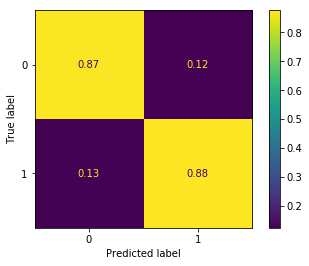

In [35]:
y_train_pred = pipeline.predict(X_train)

print(classification_report(y_train, y_train_pred))

ConfusionMatrixDisplay(confusion_matrix(y_train, y_train_pred, normalize="pred")).plot();

## 3.2 [Results]  Check on test set

              precision    recall  f1-score   support

           0       0.69      0.81      0.74       500
           1       0.59      0.42      0.49       318

    accuracy                           0.66       818
   macro avg       0.64      0.61      0.62       818
weighted avg       0.65      0.66      0.64       818



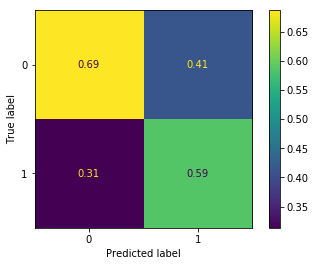

In [45]:
y_test_pred = pipeline.predict(X_test)

print(classification_report(y_test, y_test_pred))

ConfusionMatrixDisplay(confusion_matrix(y_test, y_test_pred, normalize="pred")).plot();

# 4. Explanability

## 4.1 [Explanability] SHAP-values